In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [57]:
df = pd.read_csv("bitcoin/submission.csv")

# Descriptive stats

In [58]:
# Pre-processing
df = df.dropna(subset = "selftext")
df = df[ df["removed"] != 1]

# convert to datetime
df["created_utc"] = pd.to_datetime(df["created"], unit="s")\

# Set 'datetime' column as the index
df.set_index('created_utc', inplace=True)

In [4]:
# Make a graph of the user
df.describe()

,created,retrieved,edited,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
count,1.605000e+04,1.605000e+04,1.605000e+04,16050.0,16050.0,16050.000000,16050.0,16050.000000,16050.000000,16050.000000,16050.0,16050.000000,16050.00000,16050.000000,16050.000000,16050.000000,16050.000000
mean,1.655133e+09,1.655188e+09,1.625322e+08,0.0,0.0,0.000312,0.0,0.000249,0.992399,0.000312,0.0,0.672204,23.42567,0.007290,0.154206,28.525171,0.064237
std,9.495426e+06,9.501511e+06,4.924072e+08,0.0,0.0,0.017648,0.0,0.015785,0.086856,0.017648,0.0,0.213842,87.61678,0.092104,0.885118,66.247822,0.350246
min,1.640996e+09,1.641140e+09,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.040000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.646612e+09,1.646657e+09,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.500000,0.00000,0.000000,0.000000,5.000000,0.000000
50%,1.654359e+09,1.654405e+09,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.690000,3.00000,0.000000,0.000000,11.000000,0.000000
75%,1.663212e+09,1.663261e+09,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.840000,11.00000,0.000000,0.000000,25.000000,0.000000
max,1.672530e+09,1.672537e+09,1.672529e+09,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,2450.00000,3.000000,35.000000,1884.000000,13.000000


In [5]:
unique_users = df["author"].unique()
# Count nb of posts per user
posts_per_user = df["author"].value_counts()

In [6]:
posts_per_user.sort_values(ascending=False, inplace=True)

<Axes: >

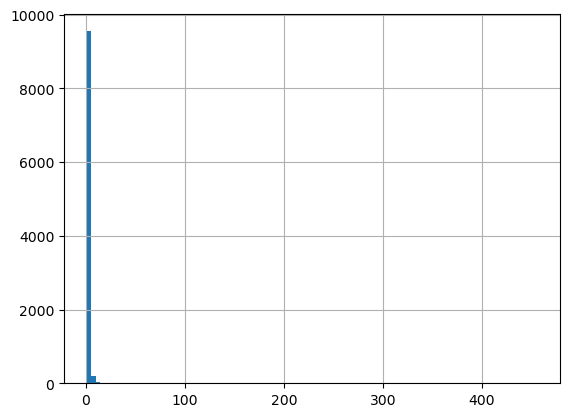

In [7]:
posts_per_user.hist(bins=100)

# Transformers pipeline

In [13]:
from transformers import pipeline, AutoTokenizer

MODEL = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)


In [26]:
def remove_special_chars(text):
    return ''.join(e for e in text if e.isalnum() or e.isspace())

In [30]:
sentiments_label = []
sentiments_score = []
for txt in tqdm(df["selftext"].values):
    txt = remove_special_chars(txt)
    try:
        sentiment = sentiment_task(txt)
        sentiments_label.append(sentiment[0]["label"])
        sentiments_score.append(sentiment[0]["score"])
    except Exception as e:
        sentiments_label.append("N/A")
        sentiments_score.append(0)

100%|██████████| 16050/16050 [05:26<00:00, 49.20it/s]


In [59]:
df["sentiment_label"] = sentiments_label
df["sentiment_score"] = sentiments_score

<Axes: xlabel='sentiment_label'>

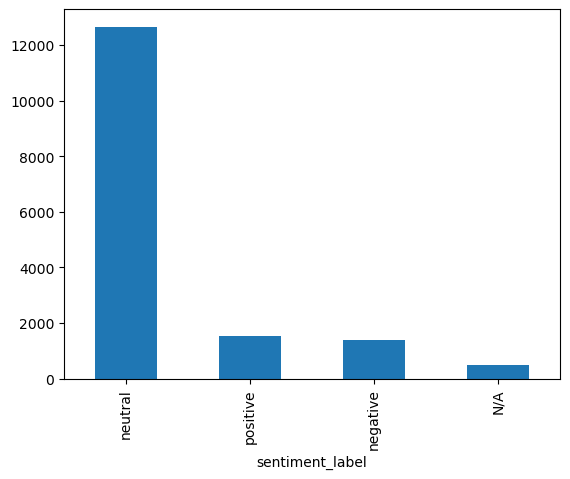

In [60]:
df["sentiment_label"].value_counts().plot(kind="bar")

In [ ]:
df[mq]

In [38]:
# convert to datetime
df["created_utc"] = pd.to_datetime(df["created"], unit="s")

In [69]:
lag = "24H"

mask_positive = df["sentiment_label"] == "positive"
mask_negative = df["sentiment_label"] == "negative"
mask_both = mask_positive | mask_negative

df["positive_score"] = 0
df.loc[mask_positive, 'positive_score'] = df[mask_positive]["sentiment_score"].values
df["negative_score"] = 0
df.loc[mask_negative, 'negative_score'] = df[mask_negative]["sentiment_score"].values


df["rolling_positive_score"] = df["positive_score"].rolling(lag).sum()
df["rolling_negative_score"] = df["negative_score"].rolling(lag).sum()

df["alpha"] = (df["rolling_positive_score"] - df["rolling_negative_score"]) / (df["rolling_positive_score"] + df["rolling_negative_score"] + 1e-4)

/tmp/ipykernel_4046730/963834529.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9988237  0.99891353 0.99970275 ... 0.99892348 0.99837887 0.98968303]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask_positive, 'positive_score'] = df[mask_positive]["sentiment_score"].values
/tmp/ipykernel_4046730/963834529.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.79209077 0.99551231 0.57348925 ... 0.994331   0.7332291  0.94990015]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask_negative, 'negative_score'] = df[mask_negative]["sentiment_score"].values
/tmp/ipykernel_4046730/963834529.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["rolling_positive_score"

<Axes: >

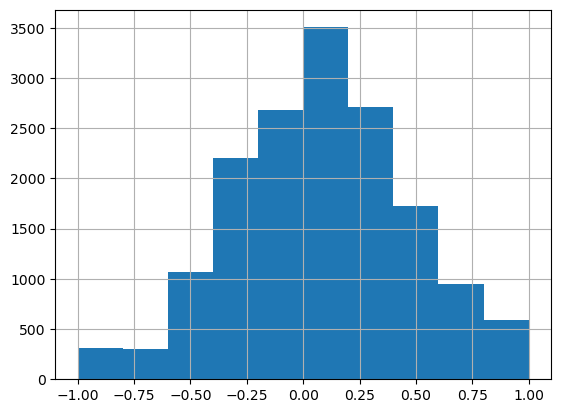

In [70]:
df["alpha"].hist()

<Axes: xlabel='created_utc'>

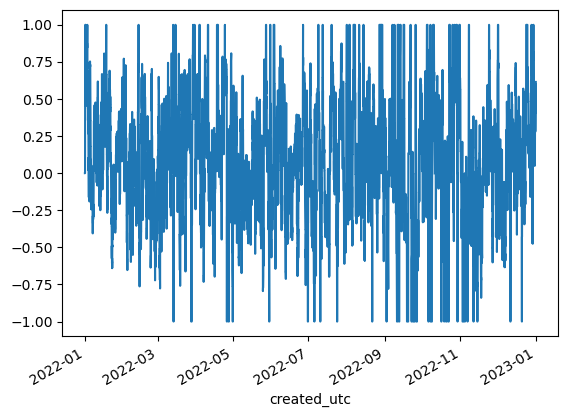

In [71]:
df["alpha"].plot()


In [72]:
df

,submission,subreddit,author,created,retrieved,edited,pinned,archived,locked,removed,...,thumbnail,shortlink,sentiment_label,sentiment_score,positive_score,f,negative_score,rolling_positive_score,rolling_negative_score,alpha
created_utc,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:17:38,rt711v,bitcoin,Squigglywiggler,1640996258,1641140399,0,0,0,0,0,...,self,https://redd.it/rt711v,neutral,0.999877,0.0,NaN,0.0,0.000000,0.000000,0.000000
2022-01-01 00:55:55,rt7qa5,bitcoin,SilverAndAlgorand,1640998555,1641140399,0,0,0,0,0,...,self,https://redd.it/rt7qa5,neutral,0.999750,0.0,NaN,0.0,0.000000,0.000000,0.000000
2022-01-01 01:06:06,rt7x3t,bitcoin,Geoknysis,1640999166,1641140399,0,0,0,0,0,...,self,https://redd.it/rt7x3t,neutral,0.999862,0.0,NaN,0.0,0.000000,0.000000,0.000000
2022-01-01 01:20:37,rt86pj,bitcoin,Mannycass,1641000037,1641140399,0,0,0,0,0,...,self,https://redd.it/rt86pj,neutral,0.999772,0.0,NaN,0.0,0.000000,0.000000,0.000000
2022-01-01 03:07:40,rta3p4,bitcoin,Still_Hat6758,1641006460,1641140399,0,0,0,0,0,...,self,https://redd.it/rta3p4,neutral,0.999276,0.0,NaN,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:40:39,1004e15,bitcoin,Physical_Proposal_80,1672522839,1672536965,0,0,0,0,0,...,self,https://redd.it/1004e15,neutral,0.999853,0.0,NaN,0.0,3.985126,1.683129,0.406114
2022-12-31 21:58:14,1004qpv,bitcoin,euodeioserbrasileiro,1672523894,1672536965,0,0,0,0,0,...,self,https://redd.it/1004qpv,neutral,0.999852,0.0,NaN,0.0,3.985126,1.683129,0.406114
2022-12-31 22:36:23,1005i5m,bitcoin,bamboochar,1672526183,1672536965,1672526489,0,0,0,0,...,self,https://redd.it/1005i5m,neutral,0.999894,0.0,NaN,0.0,3.985126,1.683129,0.406114


In [73]:
df.to_csv("bitcoin/sentiment.csv")